In [11]:
!wget https://github.com/nitrogenlab/pyompa/blob/dev/examples/FK_ompa_04s.mat?raw=true -O FK_ompa_04s.mat

!wget https://github.com/nitrogenlab/pyompa/blob/dev/examples/FK_26_27_s_nospic_results.mat?raw=true -O FK_26_27_s_nospic_results.mat

--2021-11-22 02:31:24--  https://github.com/nitrogenlab/pyompa/blob/dev/examples/FK_ompa_04s.mat?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/nitrogenlab/pyompa/raw/dev/examples/FK_ompa_04s.mat [following]
--2021-11-22 02:31:24--  https://github.com/nitrogenlab/pyompa/raw/dev/examples/FK_ompa_04s.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nitrogenlab/pyompa/dev/examples/FK_ompa_04s.mat [following]
--2021-11-22 02:31:24--  https://raw.githubusercontent.com/nitrogenlab/pyompa/dev/examples/FK_ompa_04s.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected

In [12]:
import scipy.io
from scipy.io import loadmat

#replicating from the data that Talia sent over
inp_data = loadmat("FK_ompa_04s.mat")
matlab_ompa_results = loadmat("FK_26_27_s_nospic_results.mat")

In [13]:
import pandas as pd

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "nitrate", "silicate", "spiciness"])
    df["mass"] = 1
    return df

#                                   temp       sal         oxy     PO4     NO3    Si      spic
CW13_FK =        ["13CW_FK",       12.54,    34.98,       0.59,   2.73,   23.2,   50,     1.58]
NEPIW_FK =       ["NEPIW_FK",       9.56,    34.80,       0.64,   3.1,    35,     50,     0.894]
AAIW =           ["AAIW",        6.03,    34.70,       4.8,    3.48,   46.8,   60,     0.418]

intermediatewaters_FK_endmemberdf = prepare_endmember_df([CW13_FK, NEPIW_FK, AAIW])

falkor_df = pd.DataFrame({
    'lat': inp_data['lat'].flatten(),
    'long': inp_data['long'].flatten(),
    'pdens': inp_data['pdens'].flatten(),
    'pressure': inp_data['press'].flatten(),
    'Iodate': inp_data['Iodate'].flatten(),
    'Iodide': inp_data['Iodide'].flatten(),
    'nitrate': inp_data['NO2'].flatten(),
    'oxygen': inp_data['oxy'].flatten(),
    'phosphate': inp_data['ph'].flatten(),
    'conservative_temp': inp_data['ptemp'].flatten(),
    'absolute_salinity': inp_data['sal'].flatten(),
    'spiciness': inp_data['pvort'].flatten()
})
falkor_df["mass"] = 1.0

In [15]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!git checkout dev
!git log -1
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

intermediatewaters_falkordf = pd.DataFrame(falkor_df[(falkor_df["pdens"] >= 26.0)
                                                     & (falkor_df["pdens"] <= 27.0)])

evansorig_convertedparamgroups = [
    pyompa.ConvertedParamGroup(groupname="phosphate_remin",
                               conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
                               always_positive=True)
]

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "spiciness": 7.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

evansorig_settings_nospiciness = {
    "param_names": ["conservative_temp", "absolute_salinity", "oxygen", "phosphate", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    "sumtooneconstraint": False,
    "standardize_by_watertypes": True
}

##
#G2
#   23.2964    1.3502  -24.6466         0
#   25.9352   -4.5105  -21.4247         0
#   -4.1137   -3.9688    8.0825 -492.4803
#   -1.9911   -0.0178    2.0088    5.3332
#   24.0000   24.0000   24.0000         0

#
#mean
#    9.3767   34.8267    2.0100    3.1033    1.0000
#std
#    3.2589    0.1419    2.4163    0.3750         0

intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **evansorig_settings_nospiciness).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

/content
Cloning into 'pyompa'...
remote: Enumerating objects: 1208, done.
remote: Counting objects: 100% (516/516), done.
remote: Compressing objects: 100% (343/343), done.
remote: Total 1208 (delta 363), reused 302 (delta 170), pack-reused 692
Receiving objects: 100% (1208/1208), 14.91 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (849/849), done.
/content/pyompa
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit 0ba369ef72c7614093bbd67b369f17e47565bce2 (HEAD -> dev, origin/dev)
Merge: 08097a1 7978a5b
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Sun Oct 24 15:17:08 2021 -0700

    Merge branch 'debug' into dev
Processing /content/pyompa
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove suppor

In [16]:
import numpy as np

np.max(np.abs(intermediate_falkordf_ompasoln.endmember_fractions - matlab_ompa_results['A'].T))

1.963984530561902e-12

In [17]:
np.max(np.abs(intermediate_falkordf_ompasoln.groupname_to_totalconvertedvariable['phosphate_remin']*170
- matlab_ompa_results['biogeo'].flatten()))

3.34199222248199e-14

In [18]:
np.max(np.abs(intermediate_falkordf_ompasoln.param_residuals - matlab_ompa_results['err'].T))

5.118749868415762e-11

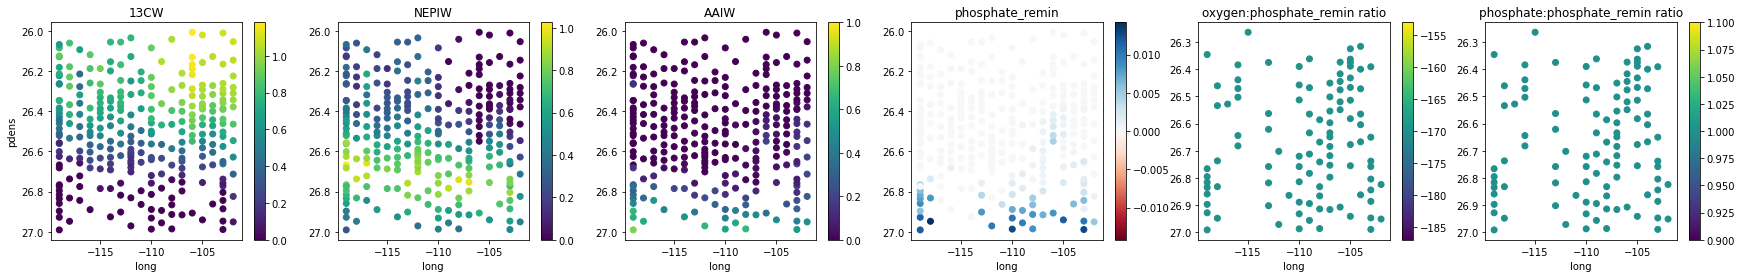

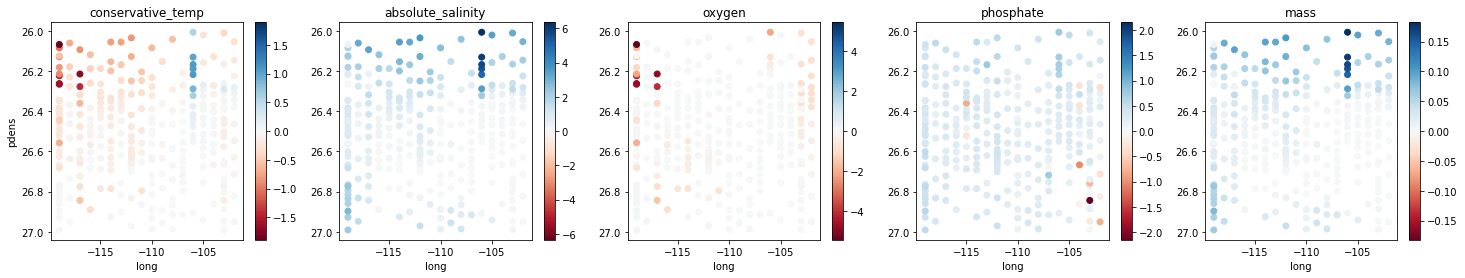

In [19]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
plot_ompasoln_endmember_fractions(ompa_soln=intermediate_falkordf_ompasoln,
                                  xaxis_colname="long",
                                  yaxis_colname=yaxis_colname)
plot_ompasoln_residuals(ompa_soln=intermediate_falkordf_ompasoln,
                        xaxis_colname="long",
                        yaxis_colname=yaxis_colname)

